# Coupon recommender system (my approach)

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import linear_kernel  
from ast import literal_eval
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
reader = Reader()

In [2]:
coupon_list_train = pd.read_csv('input/coupon_list_train_translated.csv')
coupon_list_test = pd.read_csv('input/coupon_list_test_translated.csv')
user_list = pd.read_csv('input/user_list.csv')
coupon_purchases_train = pd.read_csv("input/coupon_detail_train.csv")

coupon_area_train = pd.read_csv('input/coupon_area_train.csv')
coupon_area_test = pd.read_csv('input/coupon_area_test.csv')
coupon_visit_train = pd.read_csv('input/coupon_visit_train.csv')


## Demographic Filtering

### * Bigger discounts

In [3]:
bigger_discount = coupon_list_train.sort_values('DISCOUNT_PRICE', ascending=False)

* The top 10 bigger discounts

Text(0.5, 1.0, 'Bigger Discounts')

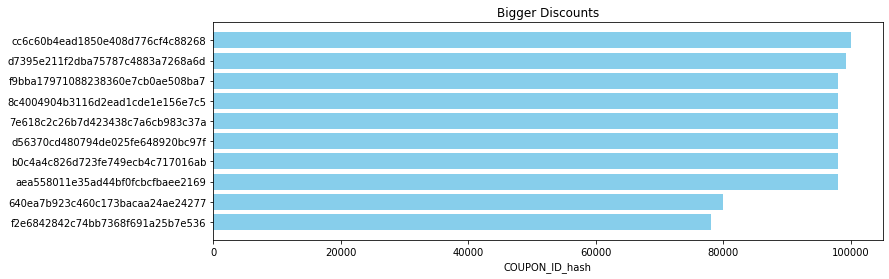

In [4]:
plt.figure(figsize=(12,4))

plt.barh(bigger_discount['COUPON_ID_hash'].head(10), bigger_discount['DISCOUNT_PRICE'].head(10), align='center', color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("COUPON_ID_hash")
plt.title("Bigger Discounts")

### * Best discounts

In [5]:
def calculate_percentage(x):
    r = x['CATALOG_PRICE']-x['DISCOUNT_PRICE']

    return ((x['CATALOG_PRICE']-r)/x['CATALOG_PRICE']) * 100

In [6]:
best_discount = coupon_list_train.copy()
best_discount = best_discount[best_discount['DISCOUNT_PRICE'] != 0]
best_discount['discountpercentage'] = best_discount.apply(lambda x: calculate_percentage(x), axis = 1)
best_discount = best_discount.sort_values('discountpercentage', ascending = False)

In [7]:
best_discount

,CAPSULE_TEXT,GENRE_NAME,PRICE_RATE,CATALOG_PRICE,DISCOUNT_PRICE,DISPFROM,DISPEND,DISPPERIOD,VALIDFROM,VALIDEND,...,USABLE_DATE_FRI,USABLE_DATE_SAT,USABLE_DATE_SUN,USABLE_DATE_HOLIDAY,USABLE_DATE_BEFORE_HOLIDAY,large_area_name,ken_name,small_area_name,COUPON_ID_hash,discountpercentage
19116,Delivery service,Delivery service,0,2270,2270,2012-06-14 12:00:00,2012-06-18 12:00:00,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,関東,東京都,銀座・新橋・東京・上野,40b6b0acb2d04f93a86034aadf461a9f,100.000000
19022,Delivery service,Delivery service,0,29800,29800,2012-06-12 12:00:00,2012-06-19 12:00:00,7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,関東,東京都,渋谷・青山・自由が丘,677f1d657534fece0b83f43fae2bd924,100.000000
18203,Delivery service,Delivery service,0,2580,2580,2012-05-24 12:00:00,2012-05-27 12:00:00,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,関東,東京都,渋谷・青山・自由が丘,9ffff0bd2762f27aa0a464714ae0748b,100.000000
18202,Delivery service,Delivery service,0,2580,2580,2012-05-30 12:00:00,2012-06-02 12:00:00,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,関東,東京都,渋谷・青山・自由が丘,283e6093e8b2c25b8c6593a9e34e8a45,100.000000
18201,Delivery service,Delivery service,0,2080,2080,2012-05-28 12:00:00,2012-05-31 12:00:00,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,関東,東京都,渋谷・青山・自由が丘,72bebf37954f66b9fb4027672001b154,100.000000
18200,Delivery service,Delivery service,0,2080,2080,2012-06-03 12:00:00,2012-06-06 12:00:00,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,関東,東京都,渋谷・青山・自由が丘,316e87b99f2d80fd132e679fc0f20c1e,100.000000
18199,Delivery service,Delivery service,0,2580,2580,2012-05-25 12:00:00,2012-05-28 12:00:00,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,関東,東京都,渋谷・青山・自由が丘,bea8750abf336ba2c66740fb3e4820ee,100.000000
18198,Delivery service,Delivery service,0,2580,2580,2012-06-02 12:00:00,2012-06-05 12:00:00,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,関東,東京都,渋谷・青山・自由が丘,186df7731ebcfd3400af5c87d07487ff,100.000000
18197,Delivery service,Delivery service,0,2580,2580,2012-05-26 12:00:00,2012-05-29 12:00:00,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,関東,東京都,渋谷・青山・自由が丘,0b883747c0c4b6ade9b03f7b44b5085a,100.000000
18196,Delivery service,Delivery service,0,2480,2480,2012-06-01 12:00:00,2012-06-04 12:00:00,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,関東,東京都,渋谷・青山・自由が丘,58f1ff5aeecc524d1637d2d0dbca3769,100.000000


Text(0.5, 1.0, 'Bigger Discounts')

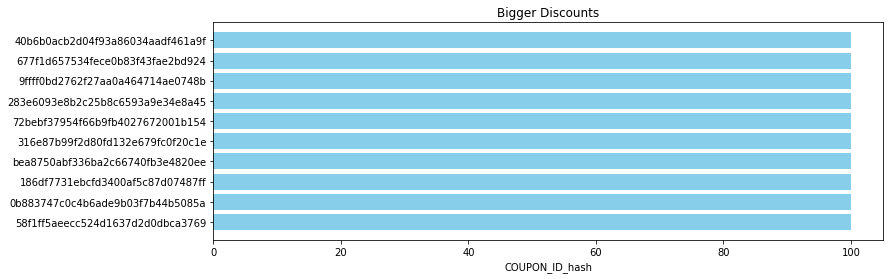

In [8]:
plt.figure(figsize=(12,4))

plt.barh(best_discount['COUPON_ID_hash'].head(10), best_discount['discountpercentage'].head(10), align='center', color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("COUPON_ID_hash")
plt.title("Bigger Discounts")

## Content Based Filtering

In [9]:
df2 = coupon_list_train.copy()

In [10]:
tfidf = TfidfVectorizer(stop_words='english')
df2['CAPSULE_TEXT'] = df2['CAPSULE_TEXT'].fillna('')
tfidf_matrix = tfidf.fit_transform(df2['CAPSULE_TEXT']) 
tfidf_matrix.shape

(19413, 32)

### * **Over 32 different Discount Categorys were used to describe the 19413 discounts in our dataset.**

In [11]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [12]:
df2.index

RangeIndex(start=0, stop=19413, step=1)

In [13]:
indices = pd.Series(df2.index, index = df2['COUPON_ID_hash'])
indices


COUPON_ID_hash
6b263844241eea98c5a97f1335ea82af        0
cc031f250e8bad1e24060263b9fc0ddd        1
ba5e9b7453ca52ff711635a5d2e8102d        2
3e1ffbedca3569f9e8032d401e8cb4e6        3
782934b6c815b4030ea204eef7d4a734        4
439db4336f84d4e4a13290fc0d7e6c4e        5
c9144a97ed61cb778414b758c704d828        6
2b00d8dfc1a9fcf58e5014cbfd4a1e48        7
74e3a12659d38ef20378f156cfeaf204        8
8a0ab8c5dd5014df8b4860233238ed44        9
5544cd0309f920f50f7e0d7e7d6fa69f       10
6eda8088f6394d430f1a1e0abf619f6a       11
305d6620db89f174eae5071749397446       12
784d04cd55f5eaf24b5b2a361dca722d       13
e0a410ff611abefbfb57ca262dcdf42e       14
b286f6fb50a4f849e4382c9752405d7a       15
8d7006385aa6e12ffbc519c053a9ab19       16
4674ac722f4a15cec7ee28cf9225d808       17
11793f5763195a4532087cb1e771c356       18
634b06c096f032220506d3e0c9557fe8       19
c6df1aa327fe4842d9ec3ae5d73c824b       20
30bcacc6cb48ffd08a8c495bff6534c8       21
5b62c9549a9b98b4ee5adc4fa109e924       22
324766d5ca086bca254

In [14]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the discount that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all discounts with that discount
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the discount based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar discounts
    sim_scores = sim_scores[1:11]

    # Get the discount indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar discounts
    return df2['COUPON_ID_hash'].iloc[movie_indices]

In [15]:
get_recommendations('2907c7009d37a625ac610f7ba90bb2c9')

261    8fea8c572ce65b1a238cb9b4fddbf0a7
264    6662785a5c767aca2fbd8c1ab0b7d356
269    90f93f1446131886ee8658b8917e8688
270    4592682e96cfc074e5bd01f315eabd87
274    1f9dbdadae08e4119e739eee53e6dc7d
275    38061d35363288ade697f51bb8e34b1b
293    f7faead5774499a1e798c4d012be8255
310    a1b2a1376c8399222f81d51706a5c4f4
314    2aecf31a6f3ec6212a223debc8876274
320    332adf06e68630e6be7072d34cf386f4
Name: COUPON_ID_hash, dtype: object

In [16]:
df2[df2.COUPON_ID_hash.isin(get_recommendations('2907c7009d37a625ac610f7ba90bb2c9').values)]

,CAPSULE_TEXT,GENRE_NAME,PRICE_RATE,CATALOG_PRICE,DISCOUNT_PRICE,DISPFROM,DISPEND,DISPPERIOD,VALIDFROM,VALIDEND,...,USABLE_DATE_THU,USABLE_DATE_FRI,USABLE_DATE_SAT,USABLE_DATE_SUN,USABLE_DATE_HOLIDAY,USABLE_DATE_BEFORE_HOLIDAY,large_area_name,ken_name,small_area_name,COUPON_ID_hash
261,Spa,Spa,66,12000,3980,2011-07-13 12:00:00,2011-07-16 12:00:00,3,2011-07-18,2012-01-13,...,1.0,1.0,0.0,0.0,0.0,0.0,関西,大阪府,ミナミ他,8fea8c572ce65b1a238cb9b4fddbf0a7
264,Spa,Spa,81,21000,3980,2011-07-21 12:00:00,2011-07-23 12:00:00,2,2011-07-24,2011-09-30,...,1.0,1.0,1.0,1.0,1.0,1.0,北海道,北海道,北海道,6662785a5c767aca2fbd8c1ab0b7d356
269,Spa,Spa,78,16525,3570,2011-07-02 12:00:00,2011-07-03 12:00:00,1,2011-07-04,2011-10-31,...,1.0,1.0,1.0,0.0,0.0,1.0,東海,愛知県,愛知,90f93f1446131886ee8658b8917e8688
270,Spa,Spa,80,14700,2940,2011-08-23 12:00:00,2011-08-26 12:00:00,3,2011-08-27,2012-02-22,...,1.0,1.0,1.0,0.0,1.0,1.0,東海,愛知県,愛知,4592682e96cfc074e5bd01f315eabd87
274,Spa,Spa,80,17250,3400,2011-07-20 12:00:00,2011-07-22 12:00:00,2,2011-07-23,2011-10-20,...,1.0,1.0,1.0,1.0,1.0,1.0,関西,京都府,京都,1f9dbdadae08e4119e739eee53e6dc7d
275,Spa,Spa,80,17250,3400,2011-08-10 12:00:00,2011-08-13 12:00:00,3,2011-08-14,2011-11-11,...,1.0,1.0,1.0,1.0,1.0,1.0,関西,京都府,京都,38061d35363288ade697f51bb8e34b1b
293,Spa,Spa,86,24150,3150,2011-07-18 12:00:00,2011-07-19 12:00:00,1,2011-07-20,2011-10-31,...,1.0,1.0,1.0,1.0,1.0,1.0,関東,千葉県,千葉,f7faead5774499a1e798c4d012be8255
310,Spa,Spa,79,14700,2980,2011-08-26 12:00:00,2011-08-29 12:00:00,3,2011-08-30,2012-02-25,...,1.0,1.0,1.0,1.0,1.0,1.0,東海,愛知県,愛知,a1b2a1376c8399222f81d51706a5c4f4
314,Spa,Spa,79,18250,3675,2011-09-14 12:00:00,2011-09-17 12:00:00,3,2011-09-18,2011-12-16,...,1.0,1.0,1.0,0.0,1.0,1.0,関東,神奈川県,横浜,2aecf31a6f3ec6212a223debc8876274
320,Spa,Spa,81,5250,950,2011-12-06 12:00:00,2011-12-09 12:00:00,3,2011-12-10,2012-06-05,...,1.0,1.0,1.0,1.0,1.0,1.0,九州・沖縄,長崎県,長崎,332adf06e68630e6be7072d34cf386f4


## Collaborative Filtering

In [17]:
df = coupon_purchases_train.copy()
df

,ITEM_COUNT,I_DATE,SMALL_AREA_NAME,PURCHASEID_hash,USER_ID_hash,COUPON_ID_hash
0,1,2012-03-28 15:06:06,兵庫,c820a8882374a4e472f0984a8825893f,d9dca3cb44bab12ba313eaa681f663eb,34c48f84026e08355dc3bd19b427f09a
1,1,2011-07-04 23:52:54,銀座・新橋・東京・上野,1b4eb2435421ede98c8931c42e8220ec,560574a339f1b25e57b0221e486907ed,767673b7a777854a92b73b0934ddfae7
2,1,2011-07-16 00:52:49,恵比寿・目黒・品川,36b5f9ba46c44b65587d0b16f2e4c77f,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2
3,1,2011-07-16 00:54:53,恵比寿・目黒・品川,2f30f46937cc9004774e576914b2aa1a,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2
4,1,2011-07-16 00:55:52,恵比寿・目黒・品川,4d000c64a55ac573d0ae1a8f03677f50,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2
5,1,2011-07-16 00:57:09,恵比寿・目黒・品川,d8b030c8a4a2c1051997092a2985b373,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2
6,2,2011-07-16 00:58:29,恵比寿・目黒・品川,2c98138766edf5d5be97ed96aa188c7d,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2
7,2,2011-09-07 00:04:47,渋谷・青山・自由が丘,5a45d62c72a4cc4155786b03bec74c96,560574a339f1b25e57b0221e486907ed,259a22533cab381464c89f616a56d12d
8,1,2011-10-19 22:21:50,渋谷・青山・自由が丘,592bb67c0553648d6ebd99a4442606f8,560574a339f1b25e57b0221e486907ed,f4a6f861a266799b07cd99c26e80962b
9,1,2011-12-01 16:53:45,恵比寿・目黒・品川,509883c481716b1f3abeac8372b36a5d,560574a339f1b25e57b0221e486907ed,4257a8a169b40bbbcb002ec47ab3de13


In [18]:
data = Dataset.load_from_df(df[['USER_ID_hash', 'COUPON_ID_hash', 'ITEM_COUNT']], reader)

svd = SVD()

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8716  0.7460  0.8146  0.7850  0.7975  0.8029  0.0411  
MAE (testset)     0.3762  0.3707  0.3712  0.3697  0.3738  0.3723  0.0024  
Fit time          7.33    6.51    6.42    6.39    6.32    6.59    0.37    
Test time         0.25    0.27    0.21    0.27    0.26    0.25    0.02    


{'test_rmse': array([0.87158373, 0.74597618, 0.81462254, 0.78503402, 0.79751926]),
 'test_mae': array([0.37616083, 0.37072389, 0.37119118, 0.36965536, 0.37376883]),
 'fit_time': (7.33247971534729,
  6.505925178527832,
  6.415802717208862,
  6.393633604049683,
  6.3168230056762695),
 'test_time': (0.24689698219299316,
  0.2736344337463379,
  0.20839333534240723,
  0.2709200382232666,
  0.26368021965026855)}

In [19]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [23]:
df[df['USER_ID_hash'] == '560574a339f1b25e57b0221e486907ed']

,ITEM_COUNT,I_DATE,SMALL_AREA_NAME,PURCHASEID_hash,USER_ID_hash,COUPON_ID_hash
1,1,2011-07-04 23:52:54,銀座・新橋・東京・上野,1b4eb2435421ede98c8931c42e8220ec,560574a339f1b25e57b0221e486907ed,767673b7a777854a92b73b0934ddfae7
2,1,2011-07-16 00:52:49,恵比寿・目黒・品川,36b5f9ba46c44b65587d0b16f2e4c77f,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2
3,1,2011-07-16 00:54:53,恵比寿・目黒・品川,2f30f46937cc9004774e576914b2aa1a,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2
4,1,2011-07-16 00:55:52,恵比寿・目黒・品川,4d000c64a55ac573d0ae1a8f03677f50,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2
5,1,2011-07-16 00:57:09,恵比寿・目黒・品川,d8b030c8a4a2c1051997092a2985b373,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2
6,2,2011-07-16 00:58:29,恵比寿・目黒・品川,2c98138766edf5d5be97ed96aa188c7d,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2
7,2,2011-09-07 00:04:47,渋谷・青山・自由が丘,5a45d62c72a4cc4155786b03bec74c96,560574a339f1b25e57b0221e486907ed,259a22533cab381464c89f616a56d12d
8,1,2011-10-19 22:21:50,渋谷・青山・自由が丘,592bb67c0553648d6ebd99a4442606f8,560574a339f1b25e57b0221e486907ed,f4a6f861a266799b07cd99c26e80962b
9,1,2011-12-01 16:53:45,恵比寿・目黒・品川,509883c481716b1f3abeac8372b36a5d,560574a339f1b25e57b0221e486907ed,4257a8a169b40bbbcb002ec47ab3de13
10,2,2012-01-15 20:53:59,渋谷・青山・自由が丘,231e87e928a48403a92783780010aef9,560574a339f1b25e57b0221e486907ed,3e7d148d632f7ee123504e37d3ee9c66
